In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from deepface import DeepFace
from concurrent.futures import ThreadPoolExecutor
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Setting up the plotting environment
set_matplotlib_formats("svg")
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Sampler
import random
from typing import List

2024-02-09 09:39:52.691086: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 09:39:52.749470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ResNet 18 Model

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [2]:
df = pd.read_csv("../../data/fer2013.csv")
df.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df[df.Usage == "Training"].emotion.value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

### Data Preprocess 

In [4]:
def preprocess_pixels(data: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'pixels' column in the DataFrame from strings to 48x48 NumPy arrays,
    normalizes the pixel values, resizes the images to 224x224, 
    and returns a new DataFrame with the updated 'pixels' column.

    Parameters:
    data (pd.DataFrame): DataFrame containing the 'pixels' column.

    Returns:
    pd.DataFrame: New DataFrame with the 'pixels' column containing 224x224 arrays.
    """
    processed_images = []

    for pixel in data['pixels']:
        # Convert string to NumPy array and reshape to 48x48
        image_array = np.fromstring(pixel, sep=' ', dtype=int).reshape(48, 48)
        
        # Normalize the pixel values
        image_array = image_array / 255.0

        # Resize image to 224x224
        image = Image.fromarray(np.uint8(image_array * 255))  # Convert to PIL Image to resize
        image = image.resize((224, 224), Image.ANTIALIAS)
        
        # Convert back to NumPy array and add to list
        image_rgb = np.repeat(image_array[..., np.newaxis], 3, axis=2)
        processed_images.append(image_rgb)
#         processed_images.append(np.array(image))

    # Create a new DataFrame with the processed images
    new_data = data.copy()
    new_data['pixels'] = processed_images

    return new_data

def split_data_by_usage(data: pd.DataFrame) -> tuple:
    """
    Splits the DataFrame into training, public test, and private test sets based on the 'Usage' column.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data and a 'Usage' column.

    Returns:
    tuple: Contains the training, public test, and private test DataFrames.
    """
    # Split the data based on the 'Usage' column
    train_data = data[data['Usage'] == 'Training']
    public_test_data = data[data['Usage'] == 'PublicTest']
    private_test_data = data[data['Usage'] == 'PrivateTest']

    return train_data, public_test_data, private_test_data

In [5]:
new_df = preprocess_pixels(df)
train_df, public_test_df, private_test_df = split_data_by_usage(new_df)

### Data Loading / Training Setup

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['pixels'].astype(np.float32)
        label = self.data.iloc[idx]['emotion']

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset objects
train_dataset = CustomDataset(new_df[new_df['Usage'] == 'Training'], transform=transform)
val_dataset = CustomDataset(new_df[new_df['Usage'] == 'PublicTest'], transform=transform)
test_dataset = CustomDataset(new_df[new_df['Usage'] == 'PrivateTest'], transform=transform)

# Create data loaders
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [95]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # set custom weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Training

In [96]:
num_epochs = 30
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    
    model.train()
    total_loss, total_correct = 0, 0

    
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_correct += (predicted == labels).sum().item()
        
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    avg_train_accuracy = total_correct / len(train_loader.dataset)
    train_accuracies.append(avg_train_accuracy)
    
    # scheduler.step()
    
    model.eval()
    total_val_loss, total_val_correct = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val_correct += (predicted == labels).sum().item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = total_val_correct / len(val_loader.dataset)
    val_accuracies.append(val_accuracy)
    
    print(f'''
    Epoch: {epoch+1}/{num_epochs}
    Training   - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}
    Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}
    ''')


    Epoch: 1/30
    Training   - Loss: 1.4035, Accuracy: 0.4749
    Validation - Loss: 2.4328, Accuracy: 0.2212
    

    Epoch: 2/30
    Training   - Loss: 1.3374, Accuracy: 0.4919
    Validation - Loss: 1.3626, Accuracy: 0.4873
    

    Epoch: 3/30
    Training   - Loss: 1.1276, Accuracy: 0.5769
    Validation - Loss: 1.2015, Accuracy: 0.5403
    

    Epoch: 4/30
    Training   - Loss: 1.0348, Accuracy: 0.6190
    Validation - Loss: 1.2595, Accuracy: 0.5442
    

    Epoch: 5/30
    Training   - Loss: 0.9492, Accuracy: 0.6485
    Validation - Loss: 1.3727, Accuracy: 0.5266
    

    Epoch: 6/30
    Training   - Loss: 0.8550, Accuracy: 0.6886
    Validation - Loss: 1.1467, Accuracy: 0.5999
    

    Epoch: 7/30
    Training   - Loss: 0.7235, Accuracy: 0.7353
    Validation - Loss: 1.1986, Accuracy: 0.5834
    

    Epoch: 8/30
    Training   - Loss: 0.6834, Accuracy: 0.7561
    Validation - Loss: 1.4630, Accuracy: 0.5595
    

    Epoch: 9/30
    Training   - Loss: 0.4971, Accuracy

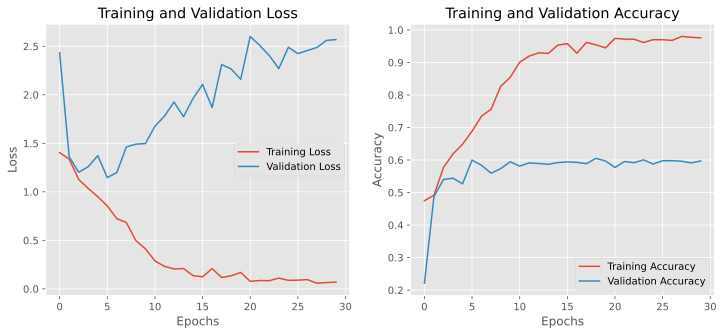

In [97]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Results

Total labels: 3589, Total predictions: 3589


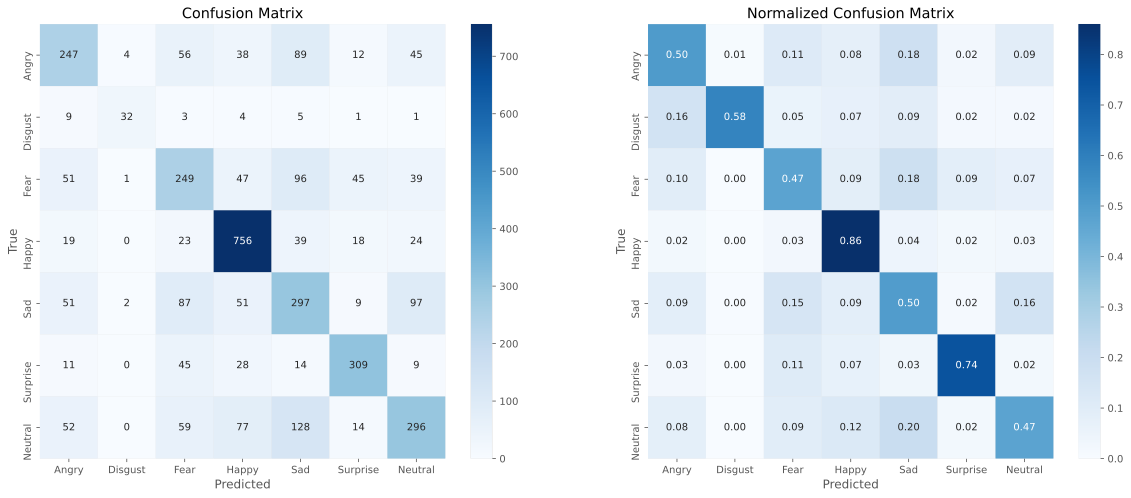

In [98]:
model.eval()  # Set the model to evaluation mode
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        
        all_labels.extend(labels.cpu().numpy().flatten())
        all_predictions.extend(predicted.cpu().numpy().flatten())
        
print(f"Total labels: {len(all_labels)}, Total predictions: {len(all_predictions)}")

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, ax=ax2)
ax2.set_title('Normalized Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.show()

In [99]:
report = classification_report(all_labels, all_predictions, target_names=emotion_labels)

# ,output_dict=True)
# report_df = pd.DataFrame(report).transpose()

print(report)

              precision    recall  f1-score   support

       Angry       0.56      0.50      0.53       491
     Disgust       0.82      0.58      0.68        55
        Fear       0.48      0.47      0.47       528
       Happy       0.76      0.86      0.80       879
         Sad       0.44      0.50      0.47       594
    Surprise       0.76      0.74      0.75       416
     Neutral       0.58      0.47      0.52       626

    accuracy                           0.61      3589
   macro avg       0.63      0.59      0.60      3589
weighted avg       0.61      0.61      0.61      3589



# DeepFace

This cell executes the DeepFace model on our image dataset to analyze emotions, age, gender, and race with batch-processing.

In [28]:
# Function to process a batch of images
def process_batch(emotion, image_files):
    batch_results = []
    for image_file in image_files:
        result = DeepFace.analyze(img_path=f"{test_data_directory}/{emotion}/{image_file}", actions=['emotion', 'age', 'race', 'gender'], enforce_detection=False)[0]
        batch_results.append((emotion, result))
    return batch_results

# Emotions to be analyzed
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
test_data_directory = "../data/data/test"

# Initialize dictionaries to store results
emotion_metric_results = {}
emotion_eda_data = {emotion: {"age": [], "gender": [], "race": []} for emotion in emotions}
aggregate_eda_data = {"age": [], "gender": [], "race": []}
all_true_labels, all_predicted_labels = [], []

# Number of batches to process for each emotion (adjust as needed)
num_batches_to_process = 2 # REMOVE THIS WHEN RUNNING FULL DATASET
batch_size = 10  

# Process each batch in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for emotion in emotions:
        # Get the image files for the emotion
        emotion_image_files = [img for img in os.listdir(f"{test_data_directory}/{emotion}") if img.endswith(".jpg")]
        
        # Divide images into batches and limit the number of batches processed
        image_batches = [emotion_image_files[i:i + batch_size] for i in range(0, len(emotion_image_files), batch_size)][:num_batches_to_process] # REMOVE THIS WHEN RUNNING FULL DATASET
        
        for batch in image_batches:
            future = executor.submit(process_batch, emotion, batch)
            futures.append(future)

    # Collect results from each batch
    for future in futures:
        batch_results = future.result()
        for emotion, analysis_result in batch_results:
            predicted_emotion = analysis_result['dominant_emotion']
            predicted_gender = analysis_result['dominant_gender']
            detected_age = analysis_result['age']
            detected_race = analysis_result['dominant_race']

            all_true_labels.append(emotion)
            all_predicted_labels.append(predicted_emotion)

            emotion_eda_data[emotion]["age"].append(detected_age)
            emotion_eda_data[emotion]["gender"].append(predicted_gender)
            emotion_eda_data[emotion]["race"].append(detected_race)

            aggregate_eda_data["age"].append(detected_age)
            aggregate_eda_data["gender"].append(predicted_gender)
            aggregate_eda_data["race"].append(detected_race)

# Calculate and store performance metrics for each emotion
for emotion in emotions:
    true_labels = [label for label in all_true_labels if label == emotion]
    predicted_labels = [all_predicted_labels[i] for i, label in enumerate(all_true_labels) if label == emotion]

    emotion_accuracy = accuracy_score(true_labels, predicted_labels)
    emotion_f1_score = f1_score(true_labels, predicted_labels, average='macro')
    emotion_recall = recall_score(true_labels, predicted_labels, average='macro')
    emotion_precision = precision_score(true_labels, predicted_labels, average='macro')

    emotion_metric_results[emotion] = {
        "Test Accuracy": emotion_accuracy,
        "F1 Score": emotion_f1_score,
        "Recall": emotion_recall,
        "Precision": emotion_precision
    }

# Generate and display the overall confusion matrix
overall_confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels, labels=emotions)
normalized_confusion_matrix = overall_confusion_matrix.astype('float') / overall_confusion_matrix.sum(axis=1)[:, np.newaxis]

print("Processing complete.")

Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]


Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: age:  25%|████████                        | 1/4 [00:00<00:00,  3.44it/s]

Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  3.07it/s]


Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  4.03it/s]

Action: age:  25%|████████                        | 1/4 [00:00<00:00,  3.07it/s]


Action: age:  25%|████████                        | 1/4 [00:00<00:00,  4.03it/s]

Action: age:  50%|████████████████                | 2/4 [00:01<00:02,  1.04s/it]


Action: age:  50%|████████████████                | 2/4 [00:01<00:02,  1.02s/it]

Action: race:  50%|███████████████▌               | 2/4 [00:01<00:02,  1.04s/it]


Action: ra

Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  5.53it/s]


Action: age:  25%|████████                        | 1/4 [00:00<00:00,  8.81it/s]

Action: age:  50%|████████████████                | 2/4 [00:00<00:00,  2.32it/s]

Action: race:  50%|███████████████▌               | 2/4 [00:00<00:00,  2.32it/s]


Action: age:  50%|████████████████                | 2/4 [00:00<00:00,  2.13it/s]


Action: race:  50%|███████████████▌               | 2/4 [00:00<00:00,  2.15it/s]

Action: race:  75%|███████████████████████▎       | 3/4 [00:01<00:00,  1.82it/s]

Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.82it/s]


Action: race:  75%|███████████████████████▎       | 3/4 [00:01<00:00,  1.77it/s]


Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.67it/s]

Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: g

Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  6.12it/s]

Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]



Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: age:  25%|████████                        | 1/4 [00:00<00:00,  6.98it/s]


Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  7.27it/s]


Action: age:  25%|████████                        | 1/4 [00:00<00:00,  7.27it/s]

Action: age:  50%|████████████████                | 2/4 [00:00<00:00,  2.21it/s]

Action: r

Action: age:  25%|████████                        | 1/4 [00:00<00:00,  7.44it/s]


Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Action: race:  50%|███████████████▌               | 2/4 [00:00<00:01,  1.93it/s]

Action: race:  75%|███████████████████████▎       | 3/4 [00:01<00:00,  1.55it/s]

Action: race:  50%|███████████████▌               | 2/4 [00:00<00:00,  2.73it/s]


Action: race:  75%|███████████████████████▎       | 3/4 [00:01<00:00,  1.61it/s]


Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.61it/s]

Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.52it/s]


Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]

Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  7.82it/s]

Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.90it/s]


Action: ge

Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]



Finding actions:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.75it/s]


Action: emotion:  25%|███████                     | 1/4 [00:00<00:00,  6.07it/s]


Action: gender: 100%|█████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]

Action: age:  25%|████████                        | 1/4 [00:00<00:00,  7.86it/s]

Action: age:  50%|████████████████                | 2/4 [00:00<00:01,  1.98it/s]

Action: emotion:   0%|                                    | 0/4 [00:00<?, ?it/s]


Action: age:  50%|████████████████                | 2/4 [00:00<00:00,  2.27it/s]


Action: race:  50%|███████████████▌               | 2/4 [00:00<00:00,  2.60it/s]

Action: race:  75%|███████████████████████▎       | 3/4 [00:01<00:00,  1.72it/s]

Action: gender:  75%|█████████████████████▊       | 3/4 [00:01<00:00,  1.72it/s]


Action: 

Processing complete.


## Exploratory Data Analysis

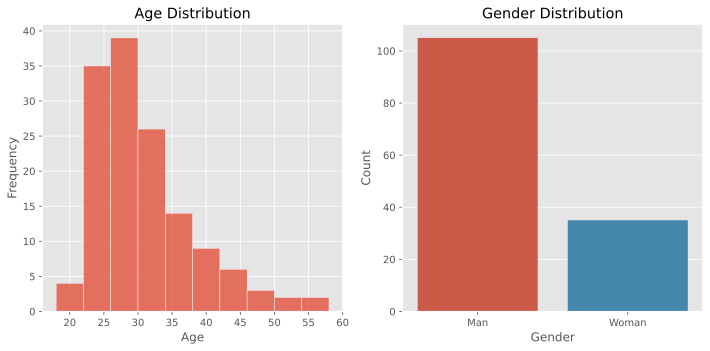

In [52]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Plotting Age Distribution
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
sns.histplot(aggregate_eda_data['age'], bins=10, kde=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plotting Gender Distribution
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
sns.countplot(x=aggregate_eda_data['gender'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')


# Adjust layout
plt.tight_layout()
plt.show()

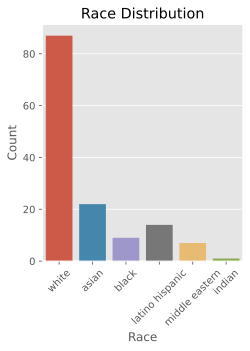

In [56]:
# Plotting Race Distribution
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
race_plot = sns.countplot(x=aggregate_eda_data['race'])
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
race_plot.set_xticklabels(race_plot.get_xticklabels(), rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()

## Test Results

### Confusion Matrices
Here, we can see visual representations of the overall and normalized confusion matrices, providing detailed insights into the accuracy of emotion predictions by the DeepFace model.




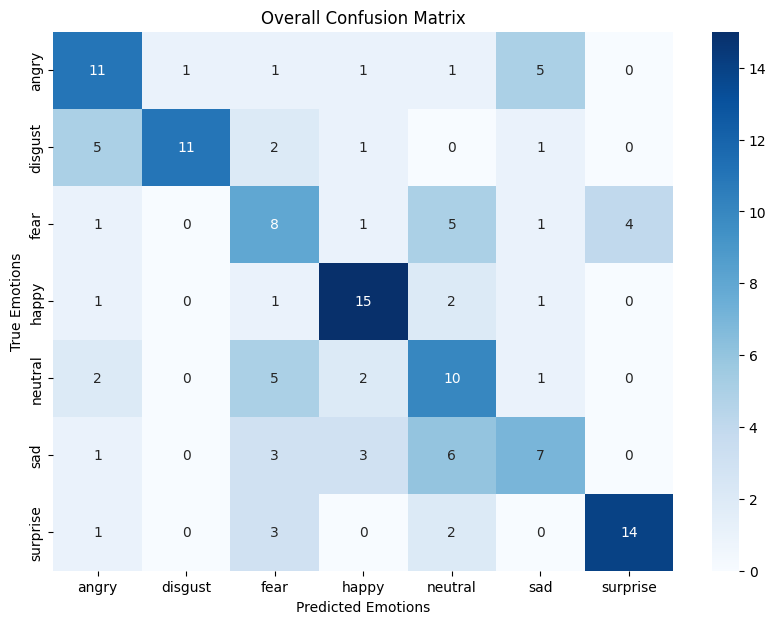

In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(overall_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')
plt.show()

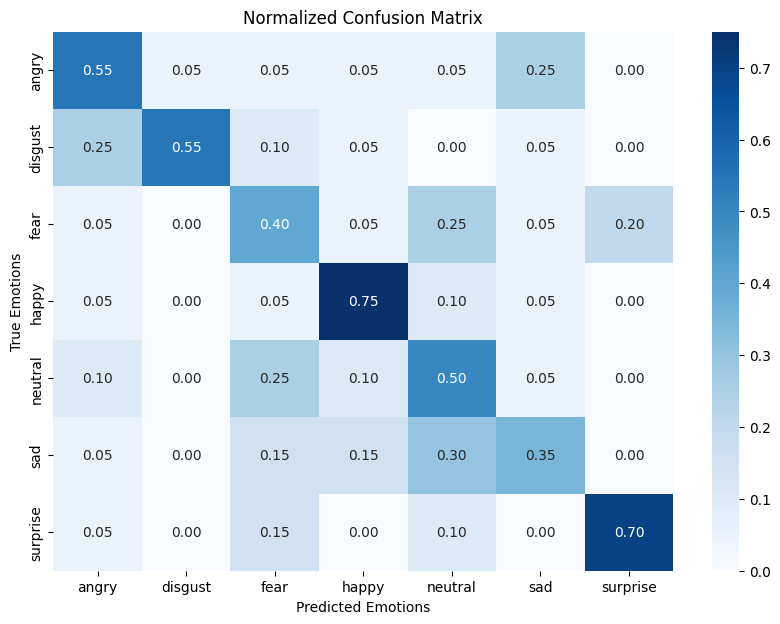

In [30]:
plt.figure(figsize=(10, 7))
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Emotions')
plt.ylabel('True Emotions')
plt.show()

### Emotion Recognition Results

Below, you'll find a summary of the performance metrics for emotion recognition by the DeepFace model. These metrics include Test Accuracy, F1 Score, Recall, and Precision, evaluated for each emotion category.


In [65]:
df_results = pd.DataFrame(emotion_metric_results).T 
df_results.index.name = 'Emotion'
df_results.columns = [col.capitalize() for col in df_results.columns]

# Display the DataFrame
df_results

,Test accuracy,F1 score,Recall,Precision
Emotion,,,,
angry,0.55,0.118280,0.091667,0.166667
disgust,0.55,0.141935,0.110000,0.200000
fear,0.40,0.095238,0.066667,0.166667
happy,0.75,0.171429,0.150000,0.200000
neutral,0.50,0.133333,0.100000,0.200000
sad,0.35,0.103704,0.070000,0.200000
surprise,0.70,0.205882,0.175000,0.250000
